[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-5/memory_agent.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/59971030-lesson-5-build-an-agent-with-long-term-memory)

# 메모리 에이전트

## 복습

우리는 시멘틱 메모리을 단일 [사용자 프로필](https://langchain-ai.github.io/langgraph/concepts/memory/#profile) 또는 [컬렉션](https://langchain-ai.github.io/langgraph/concepts/memory/#collection)에 저장하는 챗봇을 만들었습니다.

스키마를 업데이트하는 방법으로 [Trustcall](https://github.com/hinthornw/trustcall)을 도입했습니다.

## 목표

이제 배운 내용을 종합하여 장기 기억을 가진 [에이전트](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/)를 구축할 것입니다.

우리의 에이전트 `task_mAIstro`는 할 일 목록 관리를 도와줄 것입니다!

이전 채팅봇들은 *항상* 대화를 반추하고 기억을 저장했습니다.

`task_mAIstro`는 기억(할 일 목록 항목)을 저장할 *시점*을 결정합니다.

이전 채팅봇들은 항상 하나의 유형의 기억(프로필 또는 컬렉션)만 저장했습니다.

`task_mAIstro`는 사용자 프로필이나 할 일 항목 컬렉션 중 하나에 저장할지 결정할 수 있습니다.

시멘틱 메모리 외에도 `task_mAIstro`는 절차적 메모리도 관리할 것입니다.

이를 통해 사용자는 할 일 항목 생성 시 자신의 선호도를 업데이트할 수 있습니다.

In [2]:
%%capture --no-stderr

%pip install -U langchain_openai langgraph trustcall langchain_core

In [3]:
from dotenv import load_dotenv

load_dotenv("../.env", override=True)

True

In [4]:
import os
import getpass


def _set_env(var: str):
    env_value = os.environ.get(var)
    if not env_value:
        env_value = getpass.getpass(f"{var}: ")

    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
_set_env("OPENAI_API_KEY")

## Trustcall 업데이트에 대한 가시성 확보

Trustcall은 JSON 스키마를 생성하고 업데이트합니다.

Trustcall이 수행한 *구체적인 변경 사항*을 확인하고 싶다면 어떻게 해야 할까요?

예를 들어, 이전에 살펴본 바와 같이 Trustcall은 자체 도구를 통해 다음과 같은 작업을 수행합니다:

* 유효성 검사 실패 시 자체 수정 -- [추적 예시 참조](https://smith.langchain.com/public/5cd23009-3e05-4b00-99f0-c66ee3edd06e/r/9684db76-2003-443b-9aa2-9a9dbc5498b7) 
* 기존 문서 업데이트 -- [추적 예시 참조](https://smith.langchain.com/public/f45bdaf0-6963-4c19-8ec9-f4b7fe0f68ad/r/760f90e1-a5dc-48f1-8c34-79d6a3414ac3)

이러한 도구에 대한 가시성은 우리가 구축할 에이전트에 유용할 수 있습니다.

아래에서 이를 수행하는 방법을 보여드리겠습니다!

In [33]:
from pydantic import BaseModel, Field


class Memory(BaseModel):
    content: str = Field(
        description="메모리의 주요 내용입니다. 예: 사용자가 프랑스어 학습에 관심을 보였습니다."
    )


class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="사용자에 대한 메모리 목록입니다.")

Trustcall 추출기에 [리스너](https://python.langchain.com/docs/how_to/lcel_cheatsheet/#add-lifecycle-listeners)를 추가할 수 있습니다.

이렇게 하면 추출기 실행에서 발생한 실행(run) 정보가 우리가 정의할 `Spy` 클래스로 전달됩니다.

우리의 `Spy` 클래스는 Trustcall에 의해 어떤 도구 호출이 이루어졌는지에 대한 정보를 추출할 것입니다.

In [34]:
from trustcall import create_extractor
from langchain_openai import ChatOpenAI


# Trustcall이 호출한 도구를 검사합니다.
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):
        # 추출기가 호출한 도구에 대한 정보를 수집합니다.
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )


# 스파이를 초기화합니다.
spy = Spy()

# 모델을 초기화합니다.
model = ChatOpenAI(model="gpt-4o", temperature=0)

# 추출기를 생성합니다.
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

# 스파이를 리스너로 추가합니다.
trustcall_extractor_see_all_tool_calls = trustcall_extractor.with_listeners(on_end=spy)

In [35]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# 지시사항
instruction = """다음 대화에서 메모리를 추출하세요:"""

# 대화
conversation = [
    HumanMessage(content="안녕하세요, 저는 Lance입니다."),
    AIMessage(content="만나서 반갑습니다, Lance."),
    HumanMessage(content="오늘 아침 샌프란시스코에서 즐거운 자전거 라이딩을 했습니다."),
]

# 추출기 호출
result = trustcall_extractor.invoke(
    {"messages": [SystemMessage(content=instruction)] + conversation}
)

In [8]:
# 메시지에는 도구 호출이 포함됩니다.
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_MV7UokaZTXVmqKbgBOf9lh5J)
 Call ID: call_MV7UokaZTXVmqKbgBOf9lh5J
  Args:
    content: Lance는 샌프란시스코에서 자전거 라이딩을 즐겼습니다.


In [9]:
# 응답에는 스키마를 따르는 메모리가 포함됩니다.
for m in result["responses"]:
    print(m)

content='Lance는 샌프란시스코에서 자전거 라이딩을 즐겼습니다.'


In [10]:
# 메타데이터에는 도구 호출이 포함됩니다.
for m in result["response_metadata"]:
    print(m)

{'id': 'call_MV7UokaZTXVmqKbgBOf9lh5J'}


In [11]:
# 대화 업데이트
updated_conversation = [
    AIMessage(content="좋네요, 그 후에는 무엇을 하셨나요?"),
    HumanMessage(content="Tartine에 가서 크루아상을 먹었어요."),
    AIMessage(content="또 어떤 생각을 하고 계신가요?"),
    HumanMessage(
        content="일본에 대해 생각하고 있었는데, 이번 겨울에 다시 가고 싶어요!"
    ),
]

# 지시사항 업데이트
system_msg = """다음 대화를 기반으로 기존 메모리를 업데이트하고 새 메모리를 만드세요:"""

# 기존 메모리를 저장하고 ID, 키(도구 이름), 값을 부여합니다.
tool_name = "Memory"
existing_memories = (
    [
        (str(i), tool_name, memory.model_dump())
        for i, memory in enumerate(result["responses"])
    ]
    if result["responses"]
    else None
)
existing_memories

[('0', 'Memory', {'content': 'Lance는 샌프란시스코에서 자전거 라이딩을 즐겼습니다.'})]

In [12]:
# 업데이트된 대화와 기존 메모리로 추출기를 호출합니다.
result = trustcall_extractor_see_all_tool_calls.invoke(
    {"messages": updated_conversation, "existing": existing_memories}
)

In [13]:
# 메타데이터에는 도구 호출이 포함됩니다.
for m in result["response_metadata"]:
    print(m)

{'id': 'call_S7Y9nq2OQgCRkZtBYjM5aKA6', 'json_doc_id': '0'}
{'id': 'call_YskOXffFtuUELStbkAkvI1Uu'}


In [14]:
# 메시지에는 도구 호출이 포함됩니다.
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_S7Y9nq2OQgCRkZtBYjM5aKA6)
 Call ID: call_S7Y9nq2OQgCRkZtBYjM5aKA6
  Args:
    content: Lance는 샌프란시스코에서 자전거 라이딩을 즐겼습니다. Tartine에 가서 크루아상을 먹었어요. 일본에 대해 생각하고 있었는데, 이번 겨울에 다시 가고 싶어요!
  Memory (call_YskOXffFtuUELStbkAkvI1Uu)
 Call ID: call_YskOXffFtuUELStbkAkvI1Uu
  Args:
    content: Lance는 샌프란시스코에서 자전거 라이딩을 즐겼습니다. Tartine에 가서 크루아상을 먹었어요. 일본에 대해 생각하고 있었는데, 이번 겨울에 다시 가고 싶어요!


In [15]:
# 파싱된 응답
for m in result["responses"]:
    print(m)

content='Lance는 샌프란시스코에서 자전거 라이딩을 즐겼습니다. Tartine에 가서 크루아상을 먹었어요. 일본에 대해 생각하고 있었는데, 이번 겨울에 다시 가고 싶어요!'
content='Lance는 샌프란시스코에서 자전거 라이딩을 즐겼습니다. Tartine에 가서 크루아상을 먹었어요. 일본에 대해 생각하고 있었는데, 이번 겨울에 다시 가고 싶어요!'


In [16]:
# Trustcall이 호출한 도구를 검사합니다.
spy.called_tools

[[{'name': 'PatchDoc',
   'args': {'json_doc_id': '0',
    'planned_edits': 'Update the content of the Memory instance to include the new experiences and thoughts shared by the user. This includes visiting Tartine for a croissant and thinking about visiting Japan again in the winter.',
    'patches': [{'op': 'replace',
      'path': '/content',
      'value': 'Lance는 샌프란시스코에서 자전거 라이딩을 즐겼습니다. Tartine에 가서 크루아상을 먹었어요. 일본에 대해 생각하고 있었는데, 이번 겨울에 다시 가고 싶어요!'}]},
   'id': 'call_S7Y9nq2OQgCRkZtBYjM5aKA6',
   'type': 'tool_call'},
  {'name': 'Memory',
   'args': {'content': 'Lance는 샌프란시스코에서 자전거 라이딩을 즐겼습니다. Tartine에 가서 크루아상을 먹었어요. 일본에 대해 생각하고 있었는데, 이번 겨울에 다시 가고 싶어요!'},
   'id': 'call_YskOXffFtuUELStbkAkvI1Uu',
   'type': 'tool_call'}]]

In [17]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """패치와 새 메모리 모두에 대한 도구 호출에서 정보를 추출합니다.

    Args:
        tool_calls: 모델의 도구 호출 목록
        schema_name: 스키마 도구의 이름 (예: "Memory", "ToDo", "Profile")
    """

    # 변경 사항 목록 초기화
    changes = []

    for call_group in tool_calls:
        for call in call_group:
            if call["name"] == "PatchDoc":
                changes.append(
                    {
                        "type": "update",
                        "doc_id": call["args"]["json_doc_id"],
                        "planned_edits": call["args"]["planned_edits"],
                        "value": call["args"]["patches"][0]["value"],
                    }
                )
            elif call["name"] == schema_name:
                changes.append({"type": "new", "value": call["args"]})

    # 결과를 단일 문자열로 포맷팅
    result_parts = []
    for change in changes:
        if change["type"] == "update":
            result_parts.append(
                f"문서 {change['doc_id']} 업데이트됨:\n"
                f"계획: {change['planned_edits']}\n"
                f"추가된 내용: {change['value']}"
            )
        else:
            result_parts.append(f"새 {schema_name} 생성됨:\n내용: {change['value']}")

    return "\n\n".join(result_parts)

In [18]:
# spy.called_tools를 검사하여 추출 중에 정확히 무슨 일이 일어났는지 확인합니다.
schema_name = "Memory"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

문서 0 업데이트됨:
계획: Update the content of the Memory instance to include the new experiences and thoughts shared by the user. This includes visiting Tartine for a croissant and thinking about visiting Japan again in the winter.
추가된 내용: Lance는 샌프란시스코에서 자전거 라이딩을 즐겼습니다. Tartine에 가서 크루아상을 먹었어요. 일본에 대해 생각하고 있었는데, 이번 겨울에 다시 가고 싶어요!

새 Memory 생성됨:
내용: {'content': 'Lance는 샌프란시스코에서 자전거 라이딩을 즐겼습니다. Tartine에 가서 크루아상을 먹었어요. 일본에 대해 생각하고 있었는데, 이번 겨울에 다시 가고 싶어요!'}


## 에이전트 생성

선택할 수 있는 다양한 [에이전트](https://langchain-ai.github.io/langgraph/concepts/high_level/) 아키텍처가 많이 있습니다.

여기서는 간단한 [ReAct](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-implementation) 에이전트를 구현해 보겠습니다.

이 에이전트는 ToDo 목록을 생성하고 관리하는 데 도움이 되는 동반자가 될 것입니다.

이 에이전트는 세 가지 유형의 장기 기억을 업데이트하기로 결정할 수 있습니다: 

(a) 일반적인 사용자 정보로 사용자 `프로필` 생성 또는 업데이트 

(b) ToDo 목록 `컬렉션`에 항목 추가 또는 업데이트

(c) ToDo 목록에 항목을 업데이트하는 방법에 대한 자체 `지침` 업데이트

In [19]:
from typing import TypedDict, Literal


# 메모리 업데이트 도구
class UpdateMemory(TypedDict):
    """어떤 메모리 유형을 업데이트할지에 대한 결정"""

    update_type: Literal["user", "todo", "instructions"]

In [20]:
_set_env("OPENAI_API_KEY")

## 그래프 정의

메모리를 저장할지 여부를 이진 결정하는 간단한 라우터 `route_message`를 추가합니다.

메모리 컬렉션 업데이트는 이전과 같이 `write_memory` 노드에서 `Trustcall`에 의해 처리됩니다!

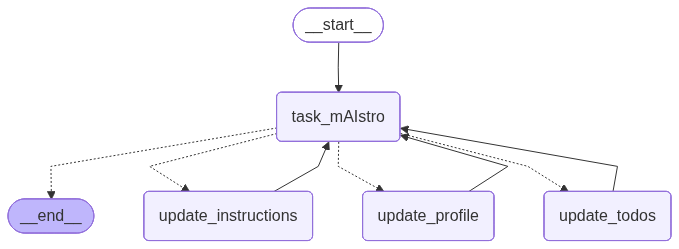

In [ ]:
import uuid
from IPython.display import Image, display
from datetime import datetime
from trustcall import create_extractor
from typing import Optional
from pydantic import BaseModel, Field
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from langchain_openai import ChatOpenAI

# 모델 초기화
model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)


# 사용자 프로필 스키마
class Profile(BaseModel):
    """채팅 중인 사용자의 프로필입니다."""

    name: Optional[str] = Field(description="사용자의 이름", default=None)
    location: Optional[str] = Field(description="사용자의 위치", default=None)
    job: Optional[str] = Field(description="사용자의 직업", default=None)
    connections: list[str] = Field(
        description="가족, 친구, 동료 등 사용자의 개인적인 관계",
        default_factory=list,
    )
    interests: list[str] = Field(description="사용자의 관심사", default_factory=list)


# ToDo 스키마
class ToDo(BaseModel):
    task: str = Field(description="완료해야 할 작업입니다.")
    time_to_complete: Optional[int] = Field(
        description="작업을 완료하는 데 예상되는 시간(분)입니다."
    )
    deadline: Optional[datetime] = Field(
        description="작업을 완료해야 하는 시점(해당하는 경우)",
        default=None,
    )
    solutions: list[str] = Field(
        description="구체적이고 실행 가능한 해결책 목록(예: 특정 아이디어, 서비스 제공업체 또는 작업 완료와 관련된 구체적인 옵션)",
        min_items=1,
        default_factory=list,
    )
    status: Literal["not started", "in progress", "done", "archived"] = Field(
        description="작업의 현재 상태", default="not started"
    )


# 사용자 프로필 업데이트를 위한 Trustcall 추출기 생성
profile_extractor = create_extractor(
    model,
    tools=[Profile],
    tool_choice="Profile",
)

# 무엇을 업데이트하고 어떤 도구를 호출할지 선택하기 위한 챗봇 지침
MODEL_SYSTEM_MESSAGE = """당신은 도움이 되는 챗봇입니다.

당신은 사용자의 동반자가 되어 그들이 ToDo 목록을 추적할 수 있도록 돕기 위해 설계되었습니다.

당신은 세 가지를 추적하는 장기 기억을 가지고 있습니다:
1. 사용자의 프로필 (그들에 대한 일반 정보)
2. 사용자의 ToDo 목록
3. ToDo 목록 업데이트를 위한 일반 지침

현재 사용자 프로필은 다음과 같습니다 (아직 수집된 정보가 없으면 비어 있을 수 있습니다):
<user_profile>
{user_profile}
</user_profile>

현재 ToDo 목록은 다음과 같습니다 (아직 추가된 작업이 없으면 비어 있을 수 있습니다):
<todo>
{todo}
</todo>

ToDo 목록 업데이트에 대한 현재 사용자 지정 기본 설정은 다음과 같습니다 (아직 지정된 기본 설정이 없으면 비어 있을 수 있습니다):
<instructions>
{instructions}
</instructions>

사용자 메시지에 대해 추론하기 위한 지침은 다음과 같습니다:

1. 아래에 제시된 사용자 메시지에 대해 신중하게 추론하십시오.

2. 장기 기억 중 어느 것이든 업데이트해야 하는지 결정하십시오:
- 사용자에 대한 개인 정보가 제공된 경우, `user` 유형으로 UpdateMemory 도구를 호출하여 사용자 프로필을 업데이트하십시오.
- 작업이 언급된 경우, `todo` 유형으로 UpdateMemory 도구를 호출하여 ToDo 목록을 업데이트하십시오.
- 사용자가 ToDo 목록 업데이트 방법에 대한 기본 설정을 지정한 경우, `instructions` 유형으로 UpdateMemory 도구를 호출하여 지침을 업데이트하십시오.

3. 적절한 경우, 기억을 업데이트했다고 사용자에게 알리십시오:
- 사용자 프로필을 업데이트했다고 사용자에게 알리지 마십시오.
- ToDo 목록을 업데이트할 때 사용자에게 알리십시오.
- 지침을 업데이트했다고 사용자에게 알리지 마십시오.

4. ToDo 목록을 업데이트하는 쪽으로 하십시오. 명시적인 허가를 요청할 필요가 없습니다.

5. 메모리를 저장하기 위해 도구 호출이 이루어졌거나 도구 호출이 이루어지지 않은 경우, 사용자에게 자연스럽게 응답하십시오."""

# Trustcall 지침
TRUSTCALL_INSTRUCTION = """다음 상호 작용을 되돌아보십시오.

제공된 도구를 사용하여 사용자에 대한 필요한 모든 기억을 유지하십시오.

병렬 도구 호출을 사용하여 업데이트와 삽입을 동시에 처리하십시오.

시스템 시간: {time}"""

# ToDo 목록 업데이트 지침
CREATE_INSTRUCTIONS = """다음 상호 작용을 되돌아보십시오.

이 상호 작용을 기반으로 ToDo 목록 항목을 업데이트하는 방법에 대한 지침을 업데이트하십시오.

사용자의 피드백을 사용하여 항목 추가 방식 등을 업데이트하십시오.

현재 지침은 다음과 같습니다:

<current_instructions>
{current_instructions}
</current_instructions>"""


# 노드 정의
def task_mAIstro(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """저장소에서 메모리를 로드하고 이를 사용하여 챗봇의 응답을 개인화합니다."""

    # config에서 사용자 ID 가져오기
    user_id = config["configurable"]["user_id"]

    # 저장소에서 프로필 메모리 검색
    namespace = ("profile", user_id)
    memories = store.search(namespace)
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None

    # 저장소에서 작업 메모리 검색
    namespace = ("todo", user_id)
    memories = store.search(namespace)
    todo = "\n".join(f"{mem.value}" for mem in memories)

    # 사용자 지정 지침 검색
    namespace = ("instructions", user_id)
    memories = store.search(namespace)
    if memories:
        instructions = memories[0].value
    else:
        instructions = ""

    system_msg = MODEL_SYSTEM_MESSAGE.format(
        user_profile=user_profile,
        todo=todo,
        instructions=instructions,
    )

    # 메모리와 채팅 기록을 사용하여 응답
    response = model.bind_tools(
        [UpdateMemory],
        parallel_tool_calls=False,
    ).invoke([SystemMessage(content=system_msg)] + state["messages"])

    return {"messages": [response]}


def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """채팅 기록을 되돌아보고 메모리 컬렉션을 업데이트합니다."""

    # config에서 사용자 ID 가져오기
    user_id = config["configurable"]["user_id"]

    # 메모리의 네임스페이스 정의
    namespace = ("profile", user_id)

    # 컨텍스트를 위해 가장 최근 메모리 검색
    existing_items = store.search(namespace)

    # Trustcall 추출기를 위해 기존 메모리 포맷팅
    tool_name = "Profile"
    existing_memories = (
        [
            (existing_item.key, tool_name, existing_item.value)
            for existing_item in existing_items
        ]
        if existing_items
        else None
    )

    # 채팅 기록과 지침 병합
    TRUSTCALL_INSTRUCTION_FORMATTED = TRUSTCALL_INSTRUCTION.format(
        time=datetime.now().isoformat()
    )
    updated_messages = list(
        merge_message_runs(
            messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)]
            + state["messages"][:-1]
        )
    )

    # 추출기 호출
    result = profile_extractor.invoke(
        {"messages": updated_messages, "existing": existing_memories}
    )

    # Trustcall의 메모리를 저장소에 저장
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(
            namespace,
            rmeta.get("json_doc_id", str(uuid.uuid4())),
            r.model_dump(mode="json"),
        )
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            {
                "role": "tool",
                "content": "updated profile",
                "tool_call_id": tool_calls[0]["id"],
            }
        ]
    }


def update_todos(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """채팅 기록을 되돌아보고 메모리 컬렉션을 업데이트합니다."""

    # config에서 사용자 ID 가져오기
    user_id = config["configurable"]["user_id"]

    # 메모리의 네임스페이스 정의
    namespace = ("todo", user_id)

    # 컨텍스트를 위해 가장 최근 메모리 검색
    existing_items = store.search(namespace)

    # Trustcall 추출기를 위해 기존 메모리 포맷팅
    tool_name = "ToDo"
    existing_memories = (
        [
            (existing_item.key, tool_name, existing_item.value)
            for existing_item in existing_items
        ]
        if existing_items
        else None
    )

    # 채팅 기록과 지침 병합
    TRUSTCALL_INSTRUCTION_FORMATTED = TRUSTCALL_INSTRUCTION.format(
        time=datetime.now().isoformat()
    )
    updated_messages = list(
        merge_message_runs(
            messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)]
            + state["messages"][:-1]
        )
    )

    # Trustcall이 호출한 도구에 대한 가시성을 위해 스파이 초기화
    spy = Spy()

    # ToDo 목록 업데이트를 위한 Trustcall 추출기 생성
    todo_extractor = create_extractor(
        model, tools=[ToDo], tool_choice=tool_name, enable_inserts=True
    ).with_listeners(on_end=spy)

    # 추출기 호출
    result = todo_extractor.invoke(
        {"messages": updated_messages, "existing": existing_memories}
    )

    # Trustcall의 메모리를 저장소에 저장
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(
            namespace,
            rmeta.get("json_doc_id", str(uuid.uuid4())),
            r.model_dump(mode="json"),
        )

    # task_mAIstro에서 이루어진 도구 호출에 응답하여 업데이트 확인
    tool_calls = state["messages"][-1].tool_calls

    # Trustcall이 만든 변경 사항을 추출하고 task_mAIstro로 반환된 ToolMessage에 추가
    todo_update_msg = extract_tool_info(spy.called_tools, tool_name)
    return {
        "messages": [
            {
                "role": "tool",
                "content": todo_update_msg,
                "tool_call_id": tool_calls[0]["id"],
            }
        ]
    }


def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """채팅 기록을 되돌아보고 메모리 컬렉션을 업데이트합니다."""

    # config에서 사용자 ID 가져오기
    user_id = config["configurable"]["user_id"]

    namespace = ("instructions", user_id)

    existing_memory = store.get(namespace, "user_instructions")

    # 시스템 프롬프트에서 메모리 포맷팅
    system_msg = CREATE_INSTRUCTIONS.format(
        current_instructions=existing_memory.value if existing_memory else None
    )
    new_memory = model.invoke(
        [SystemMessage(content=system_msg)]
        + state["messages"][:-1]
        + [HumanMessage(content="대화를 기반으로 지침을 업데이트해 주세요.")]
    )

    # 저장소의 기존 메모리를 덮어쓰기
    key = "user_instructions"
    store.put(namespace, key, {"memory": new_memory.content})
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            {
                "role": "tool",
                "content": "updated instructions",
                "tool_call_id": tool_calls[0]["id"],
            }
        ]
    }


# 조건부 엣지
def route_message(
    state: MessagesState, config: RunnableConfig, store: BaseStore
) -> Literal[
    END,
    "update_todos",
    "update_instructions",
    "update_profile",
]:
    """메모리와 채팅 기록을 되돌아보고 메모리 컬렉션을 업데이트할지 여부를 결정합니다."""

    message = state["messages"][-1]
    if len(message.tool_calls) == 0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call["args"]["update_type"] == "user":
            return "update_profile"
        elif tool_call["args"]["update_type"] == "todo":
            return "update_todos"
        elif tool_call["args"]["update_type"] == "instructions":
            return "update_instructions"
        else:
            raise ValueError


# 그래프 + 모든 노드 생성
builder = StateGraph(MessagesState)

# 메모리 추출 프로세스의 흐름 정의
builder.add_node(task_mAIstro)
builder.add_node(update_todos)
builder.add_node(update_profile)
builder.add_node(update_instructions)

builder.set_entry_point("task_mAIstro")
builder.add_conditional_edges("task_mAIstro", route_message)
builder.add_edge("update_todos", "task_mAIstro")
builder.add_edge("update_profile", "task_mAIstro")
builder.add_edge("update_instructions", "task_mAIstro")

# 장기(스레드 간) 메모리 저장소
across_thread_memory = InMemoryStore()

# 단기(스레드 내) 메모리 체크포인터
within_thread_memory = MemorySaver()

# 체크포인터와 저장소로 그래프 컴파일
graph = builder.compile(
    checkpointer=within_thread_memory,
    store=across_thread_memory,
)

# 보기
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [22]:
# 단기(스레드 내) 메모리를 위해 스레드 ID 제공
# 장기(스레드 간) 메모리를 위해 사용자 ID 제공
config = {"configurable": {"thread_id": "1", "user_id": "Lance"}}

# 프로필 메모리 생성을 위한 사용자 입력
input_messages = [
    HumanMessage(
        content="제 이름은 Lance입니다. 저는 아내와 함께 SF에 살고 있습니다. 1살 된 딸이 있습니다."
    )
]

# 그래프 실행
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

제 이름은 Lance입니다. 저는 아내와 함께 SF에 살고 있습니다. 1살 된 딸이 있습니다.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_GOMY8Af3Jq1uOuMbD1faIaJn)
 Call ID: call_GOMY8Af3Jq1uOuMbD1faIaJn
  Args:
    update_type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

안녕하세요, Lance! 어떻게 도와드릴까요? ToDo 목록에 추가할 작업이 있나요?


In [23]:
# ToDo에 대한 사용자 입력
input_messages = [HumanMessage(content="아내가 아기 수영 강습을 예약해달라고 했어요.")]

# 그래프 실행
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

아내가 아기 수영 강습을 예약해달라고 했어요.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_3Oei6PdBfOCUNQHWzYD75gf6)
 Call ID: call_3Oei6PdBfOCUNQHWzYD75gf6
  Args:
    update_type: todo
================================= Tool Message =================================

새 ToDo 생성됨:
내용: {'task': '아기 수영 강습 예약', 'time_to_complete': 30, 'solutions': ['지역 수영장에 전화하여 강습 시간 확인', '온라인으로 수영 강습 예약', '수영 강습 앱 사용'], 'status': 'not started'}
================================== Ai Message ==================================

아기 수영 강습 예약을 ToDo 목록에 추가했습니다. 다른 도움이 필요하시면 말씀해 주세요!


In [ ]:
# ToDo 생성을 위한 지침 업데이트를 위한 사용자 입력
input_messages = [
    HumanMessage(
        content="ToDo 항목을 생성하거나 업데이트할 때, 특정 지역 업체/공급업체를 포함해 주세요."
    )
]

# 그래프 실행
for chunk in graph.stream(
    {"messages": input_messages},
    config,
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

ToDo 항목을 생성하거나 업데이트할 때, 특정 지역 업체/공급업체를 포함해 주세요.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_ZnXoX81hWo0XM1IGG2MUre6T)
 Call ID: call_ZnXoX81hWo0XM1IGG2MUre6T
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

알겠습니다. 앞으로 ToDo 항목을 생성하거나 업데이트할 때, 특정 지역 업체나 공급업체를 포함하도록 하겠습니다. 다른 요청이 있으면 언제든지 말씀해 주세요!


In [25]:
# 업데이트된 지침 확인
user_id = "Lance"

# 검색
for memory in across_thread_memory.search(("instructions", user_id)):
    print(memory.value)

{'memory': "ToDo 목록 항목을 생성하거나 업데이트할 때의 지침을 다음과 같이 업데이트하겠습니다:\n\n1. **작업 추가**: 사용자가 요청한 작업을 명확하고 간결하게 ToDo 목록에 추가합니다.\n\n2. **세부 정보 포함**: 작업을 완료하는 데 필요한 세부 정보를 포함합니다. 예를 들어, 작업을 완료하는 데 걸리는 예상 시간, 사용할 수 있는 솔루션 또는 방법 등을 포함합니다.\n\n3. **지역 업체/공급업체 포함**: 사용자가 특정 지역에 거주하는 경우, 관련된 지역 업체나 공급업체를 포함하여 작업을 완료하는 데 도움이 되도록 합니다.\n\n4. **상태 설정**: 작업의 초기 상태를 'not started'로 설정합니다.\n\n5. **업데이트 요청**: 사용자가 작업을 업데이트하거나 추가 정보를 제공하도록 요청할 수 있습니다.\n\n이 지침을 통해 사용자가 ToDo 목록을 보다 효과적으로 관리할 수 있도록 지원합니다."}


In [26]:
# ToDo에 대한 사용자 입력
input_messages = [HumanMessage(content="문에 걸린 예일 전동 잠금장치를 고쳐야 해요.")]

# 그래프 실행
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

문에 걸린 예일 전동 잠금장치를 고쳐야 해요.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_7AyRGsAwItNDBjPWEwrS8MSh)
 Call ID: call_7AyRGsAwItNDBjPWEwrS8MSh
  Args:
    update_type: todo
================================= Tool Message =================================

문서 94b870dd-f26b-4896-8f85-a04111c775e9 업데이트됨:
계획: 1. Add a specific local provider to the solutions list for the existing task '아기 수영 강습 예약'.
2. Add a new ToDo item for fixing the Yale electronic lock, including specific local providers in the solutions.
추가된 내용: SF 지역 수영장

새 ToDo 생성됨:
내용: {'task': '문에 걸린 예일 전동 잠금장치 수리', 'time_to_complete': 60, 'solutions': ['예일 고객 서비스에 전화', '지역 자물쇠 수리 업체에 문의', '온라인 자물쇠 수리 서비스 예약'], 'status': 'not started'}
================================== Ai Message ==================================

문에 걸린 예일 전동 잠금장치 수리를 ToDo 목록에 추가했습니다. 다른 도움이 필요하시면 말씀해 주세요!


In [27]:
# 저장할 메모리의 네임스페이스
user_id = "Lance"

# 검색
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': '아기 수영 강습 예약', 'time_to_complete': 30, 'deadline': None, 'solutions': ['지역 수영장에 전화하여 강습 시간 확인', '온라인으로 수영 강습 예약', '수영 강습 앱 사용', 'SF 지역 수영장', 'SF 수영 강습 웹사이트'], 'status': 'not started'}
{'task': '문에 걸린 예일 전동 잠금장치 수리', 'time_to_complete': 60, 'deadline': None, 'solutions': ['예일 고객 서비스에 전화', '지역 자물쇠 수리 업체에 문의', '온라인 자물쇠 수리 서비스 예약'], 'status': 'not started'}


In [ ]:
# 기존 ToDo 업데이트를 위한 사용자 입력
input_messages = [HumanMessage(content="수영 강습은 11월 말까지 끝내야 해요.")]

# 그래프 실행
for chunk in graph.stream(
    {"messages": input_messages},
    config,
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

수영 강습은 11월 말까지 끝내야 해요.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_8qJdVsH9MVSkZXOKLXvvShwZ)
 Call ID: call_8qJdVsH9MVSkZXOKLXvvShwZ
  Args:
    update_type: todo
================================= Tool Message =================================

문서 94b870dd-f26b-4896-8f85-a04111c775e9 업데이트됨:
계획: 1. Add a deadline to the existing task '아기 수영 강습 예약' with the date set to the end of November.
추가된 내용: 2025-11-30T23:59:59
================================== Ai Message ==================================

아기 수영 강습 예약의 마감일을 11월 말로 설정했습니다. 다른 도움이 필요하시면 언제든지 말씀해 주세요!


Trustcall이 기존 메모리의 패치를 수행하는 것을 볼 수 있습니다:

https://smith.langchain.com/public/4ad3a8af-3b1e-493d-b163-3111aa3d575a/r

In [ ]:
# ToDo에 대한 사용자 입력
input_messages = [
    HumanMessage(content="City Toyota에 다시 전화해서 차량 서비스를 예약해야 해요.")
]

# 그래프 실행
for chunk in graph.stream(
    {"messages": input_messages},
    config,
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

City Toyota에 다시 전화해서 차량 서비스를 예약해야 해요.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_6kR2ymFX7v3qXHhbNPR4P1sP)
 Call ID: call_6kR2ymFX7v3qXHhbNPR4P1sP
  Args:
    update_type: todo
================================= Tool Message =================================

새 ToDo 생성됨:
내용: {'task': 'City Toyota에 차량 서비스 예약 전화', 'time_to_complete': 15, 'solutions': ['City Toyota에 직접 전화', 'City Toyota 웹사이트에서 온라인 예약', 'City Toyota 앱 사용'], 'status': 'not started'}

문서 9c934bbd-17f7-4d2f-b1de-f6672116b1b2 업데이트됨:
계획: 1. Add a specific local provider to the solutions list for the existing task '문에 걸린 예일 전동 잠금장치 수리'.
추가된 내용: SF 지역 자물쇠 수리 업체
================================== Ai Message ==================================

City Toyota에 차량 서비스 예약 전화를 ToDo 목록에 추가했습니다. 다른 도움이 필요하시면 말씀해 주세요!


In [30]:
# 저장할 메모리의 네임스페이스
user_id = "Lance"

# 검색
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': '아기 수영 강습 예약', 'time_to_complete': 30, 'deadline': '2025-11-30T23:59:59', 'solutions': ['지역 수영장에 전화하여 강습 시간 확인', '온라인으로 수영 강습 예약', '수영 강습 앱 사용', 'SF 지역 수영장', 'SF 수영 강습 웹사이트'], 'status': 'not started'}
{'task': '문에 걸린 예일 전동 잠금장치 수리', 'time_to_complete': 60, 'deadline': None, 'solutions': ['예일 고객 서비스에 전화', '지역 자물쇠 수리 업체에 문의', '온라인 자물쇠 수리 서비스 예약', 'SF 지역 자물쇠 수리 업체'], 'status': 'not started'}
{'task': 'City Toyota에 차량 서비스 예약 전화', 'time_to_complete': 15, 'deadline': None, 'solutions': ['City Toyota에 직접 전화', 'City Toyota 웹사이트에서 온라인 예약', 'City Toyota 앱 사용'], 'status': 'not started'}


이제 새 스레드를 만들 수 있습니다.

이렇게 하면 새 세션이 생성됩니다.

장기 기억에 저장된 프로필, ToDo 및 지침에 액세스합니다.

In [ ]:
# 단기(스레드 내) 메모리를 위해 스레드 ID 제공
# 장기(스레드 간) 메모리를 위해 사용자 ID 제공
config = {"configurable": {"thread_id": "2", "user_id": "Lance"}}

# 챗봇과 채팅
input_messages = [
    HumanMessage(content="30분 시간이 있는데, 어떤 작업을 할 수 있을까요?")
]

# 그래프 실행
for chunk in graph.stream(
    {"messages": input_messages},
    config,
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

30분 시간이 있는데, 어떤 작업을 할 수 있을까요?
================================== Ai Message ==================================

현재 ToDo 목록에서 30분 안에 완료할 수 있는 작업은 "아기 수영 강습 예약"입니다. 이 작업을 시작해보실 수 있습니다. 지역 수영장에 전화하거나 온라인으로 예약을 시도해보세요. 도움이 필요하시면 언제든지 말씀해 주세요!


In [ ]:
# 챗봇과 채팅
input_messages = [
    HumanMessage(content="네, 수영 강습을 위해 전화할 만한 곳 몇 군데 알려주세요.")
]

# 그래프 실행
for chunk in graph.stream(
    {"messages": input_messages},
    config,
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

네, 수영 강습을 위해 전화할 만한 곳 몇 군데 알려주세요.
================================== Ai Message ==================================

ToDo 목록에 이미 몇 가지 옵션이 있습니다. 여기 몇 가지를 추천드립니다:

1. 지역 수영장에 직접 전화하여 강습 시간을 확인하세요.
2. SF 지역 수영장 웹사이트를 방문하여 정보를 확인하세요.
3. 수영 강습 앱을 사용하여 예약을 시도해보세요.

이 외에도 도움이 필요하시면 언제든지 말씀해 주세요!


## LangSmith

트레이스:

https://smith.langchain.com/public/b6edaf4e-47c1-4fd6-b66d-c32ede297390/r

## 스튜디오

![Screenshot 2024-11-04 at 1.00.19 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732cfb05d9709862eba4e6c_Screenshot%202024-11-11%20at%207.46.40%E2%80%AFPM.png)